In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import torch
import torch.nn as nn
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
from pinns import *
from local_utils import *

from pinns import *
from intro import *

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

In [3]:
import pickle
with open(f"./inputs/solution_14.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

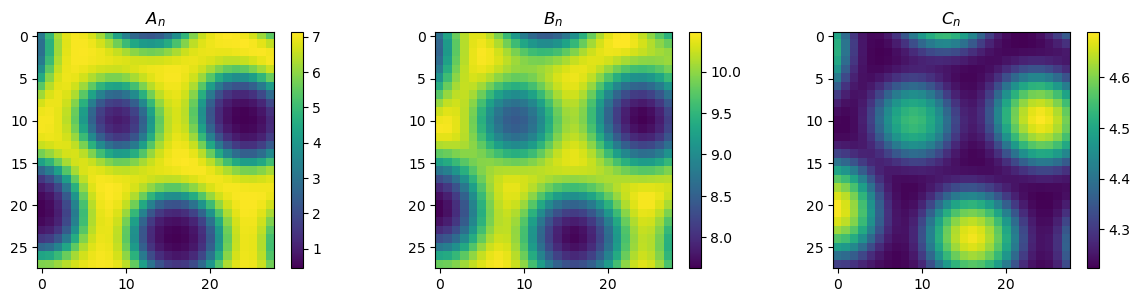

In [4]:
A_n = solution[-1, 0, :, :]
B_n = solution[-1, 1, :, :]
C_n = solution[-1, 2, :, :]

#############################################################
#    Inner boundaries
# By using these slices, we can remove the boundary effects
# or select a smaller portion of the domain
#
#   Important: slices must not be larger than slices(1,-1,1).
#              Otherwise, the boundary effects of finit difference
#              Laplacian cannot be removed
#
x_slice = slice(50,-50, 1)
y_slice = slice(50,-50, 1)

to = create_to(A_n[x_slice,y_slice])
########################################
# Take the average of data points
kernel =np.array([[1, 1],
                  [1, 1]])


A_n = ndimage.convolve(A_n, kernel)/4
B_n = ndimage.convolve(B_n, kernel)/4
C_n = ndimage.convolve(C_n, kernel)/4
############################################################
plot_n_im([A_n[x_slice,y_slice], 
           B_n[x_slice,y_slice], 
           C_n[x_slice,y_slice]], 
          [r"$A_{n}$", r"$B_{n}$", r"$C_{n}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [5]:
A_min, A_max = np.min(A_n), np.max(A_n)
B_min, B_max = np.min(B_n), np.max(B_n)
C_min, C_max = np.min(C_n), np.max(C_n)
n = 1#params["n"]
tol = .05

def define_bound(tol, n, x_min, x_max):
    upper = ((1-tol)/tol)**(1/n)
    lower = (tol/(1-tol))**(1/n)
    # return (lower, upper) bounds and the initial guess
    return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    
K_AA_bound, K_AA_init =  define_bound(tol, n, A_min, A_max)
K_AB_bound, K_AB_init =  define_bound(tol, n, A_min, A_max)
K_AC_bound, K_AC_init =  define_bound(tol, n, A_min, A_max)
K_BA_bound, K_BA_init =  define_bound(tol, n, B_min, B_max)
K_BC_bound, K_BC_init =  define_bound(tol, n, B_min, B_max)
K_CB_bound, K_CB_init =  define_bound(tol, n, C_min, C_max)
K_CC_bound, K_CC_init =  define_bound(tol, n, C_min, C_max)
n_AA_bound = (1.0, 6.0)
n_AB_bound = (1.0, 6.0)
n_AC_bound = (1.0, 6.0)
n_BA_bound = (1.0, 6.0)
n_BC_bound = (1.0, 6.0)
n_CB_bound = (1.0, 6.0)
n_CC_bound = (1.0, 6.0)


Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC":K_CC_bound}

ns_bounds = {"n_AA":n_AA_bound, 
             "n_AB":n_AB_bound, 
             "n_AC":n_AC_bound,
             "n_BA":n_BA_bound, 
             "n_BC":n_BC_bound,
             "n_CB":n_CB_bound, 
             "n_CC":n_CC_bound}

def closest_bound(name, v):
    if not (name.startswith("K") or name.startswith("n")):
        return np.nan
    if name.startswith("K"):
        lower, upper = Ks_bounds[name]
    else:
        lower, upper = ns_bounds[name]    
        
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not (name.startswith("K") or name.startswith("n")):
        return (0, None)
    if name.startswith("K"):
        return Ks_bounds[name]
    else:
        return ns_bounds[name]

In [6]:
Ks_bounds, ns_bounds

({'K_AA': (0.010698219851876205, 140.39514268911964),
  'K_AB': (0.010698219851876205, 140.39514268911964),
  'K_AC': (0.010698219851876205, 140.39514268911964),
  'K_BA': (0.35882365863211907, 204.8539562049038),
  'K_BC': (0.35882365863211907, 204.8539562049038),
  'K_CB': (0.22186441702244614, 92.88293452469931),
  'K_CC': (0.22186441702244614, 92.88293452469931)},
 {'n_AA': (1.0, 6.0),
  'n_AB': (1.0, 6.0),
  'n_AC': (1.0, 6.0),
  'n_BA': (1.0, 6.0),
  'n_BC': (1.0, 6.0),
  'n_CB': (1.0, 6.0),
  'n_CC': (1.0, 6.0)})

Epoch: 1 
 data loss:19.288281, 
data A loss:5.458422, data B loss:9.412859, data C loss:4.417000, 
Laplacian A loss:86.334300, Laplacian B loss:26.204598
Physics loss:1.763838
Negative loss:0.134072
Physics A loss:1.122068, 
Physics B loss:0.869737, Physics C loss:1.046732

 b_A=0.9000, b_B=0.9000, b_C=0.9000, V_A=1.0000, V_B=1.0000, V_C=1.0000, mu_A=0.9000, mu_B=1.1000, mu_C=0.9000, K_AA=1.0000, K_AB=1.0000, K_AC=1.0000, K_BA=1.0000, K_BC=1.0000, K_CB=1.0000, K_CC=1.0000, n_AA=2.0000, n_AB=2.0000, n_AC=2.0000, n_BA=2.0000, n_BC=2.0000, n_CB=2.0000, n_CC=2.0000


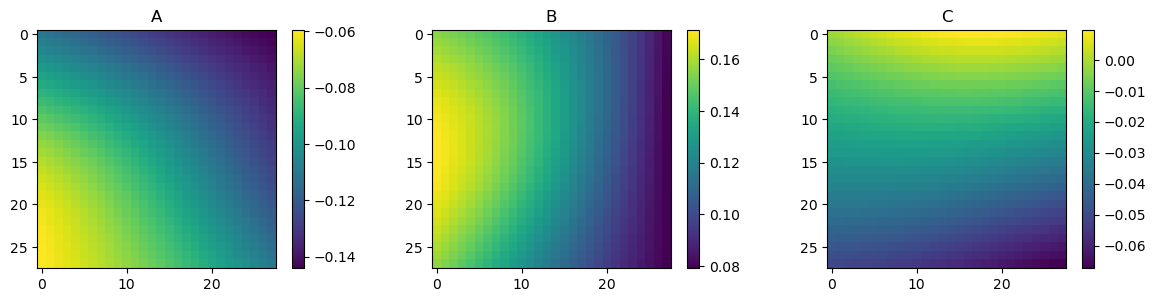

Epoch: 10000 
 data loss:0.087119, 
data A loss:0.035012, data B loss:0.022376, data C loss:0.029730, 
Laplacian A loss:0.296391, Laplacian B loss:0.123411
Physics loss:0.353106
Negative loss:0.000000
Physics A loss:0.035385, 
Physics B loss:0.351277, Physics C loss:0.006051

 b_A=0.0011, b_B=7.3701, b_C=0.0319, V_A=17.6605, V_B=172.4473, V_C=0.5920, mu_A=1.0141, mu_B=5.8061, mu_C=0.0089, K_AA=5.4668, K_AB=5.2728, K_AC=1.6385, K_BA=11.1619, K_BC=0.9824, K_CB=7.3338, K_CC=3.1554, n_AA=3.3239, n_AB=3.4098, n_AC=2.0421, n_BA=5.9563, n_BC=2.3802, n_CB=1.0000, n_CC=3.8901


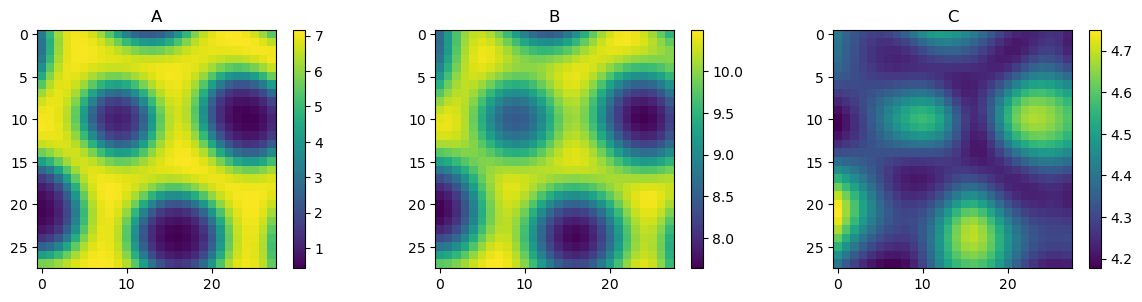

Epoch: 20000 
 data loss:0.050459, 
data A loss:0.030420, data B loss:0.009374, data C loss:0.010665, 
Laplacian A loss:0.150438, Laplacian B loss:0.064679
Physics loss:0.275789
Negative loss:0.000000
Physics A loss:0.029096, 
Physics B loss:0.274214, Physics C loss:0.004423

 b_A=0.0027, b_B=8.4771, b_C=0.0207, V_A=17.7725, V_B=171.5923, V_C=0.7514, mu_A=1.0189, mu_B=5.9431, mu_C=0.0042, K_AA=5.4934, K_AB=5.2645, K_AC=2.5012, K_BA=11.1783, K_BC=1.2334, K_CB=7.4632, K_CC=3.5467, n_AA=3.3013, n_AB=3.4116, n_AC=2.9461, n_BA=6.0000, n_BC=3.1467, n_CB=1.0000, n_CC=3.7355


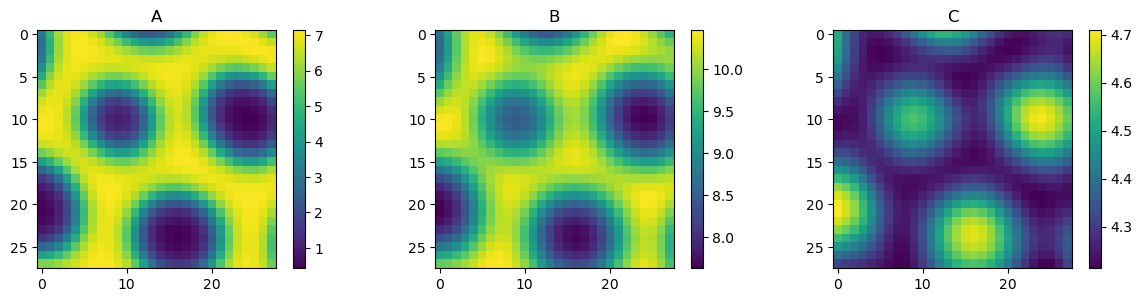

Epoch: 30000 
 data loss:0.046021, 
data A loss:0.029616, data B loss:0.008396, data C loss:0.008009, 
Laplacian A loss:0.103460, Laplacian B loss:0.055964
Physics loss:0.265006
Negative loss:0.000000
Physics A loss:0.029059, 
Physics B loss:0.263203, Physics C loss:0.010404

 b_A=0.0039, b_B=8.3121, b_C=0.0191, V_A=17.7568, V_B=171.1096, V_C=0.8635, mu_A=1.0199, mu_B=5.9217, mu_C=0.0069, K_AA=5.4895, K_AB=5.2579, K_AC=2.8233, K_BA=11.1869, K_BC=1.4772, K_CB=7.4665, K_CC=3.7764, n_AA=3.3013, n_AB=3.4192, n_AC=3.3839, n_BA=5.9789, n_BC=3.5417, n_CB=1.0000, n_CC=3.6444


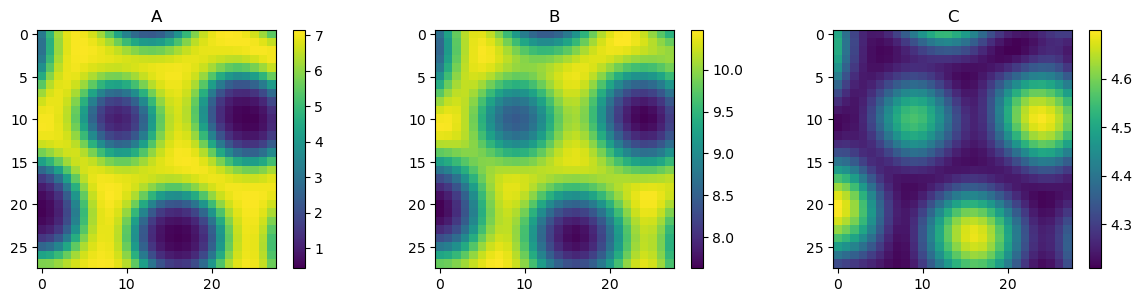

Epoch: 40000 
 data loss:0.048665, 
data A loss:0.030132, data B loss:0.009251, data C loss:0.009282, 
Laplacian A loss:0.310606, Laplacian B loss:0.094690
Physics loss:0.455051
Negative loss:0.000000
Physics A loss:0.055378, 
Physics B loss:0.451484, Physics C loss:0.012922

 b_A=0.0000, b_B=8.0689, b_C=0.0154, V_A=17.7787, V_B=170.7580, V_C=0.9433, mu_A=1.0229, mu_B=5.8989, mu_C=0.0070, K_AA=5.5019, K_AB=5.2647, K_AC=3.1895, K_BA=11.1794, K_BC=1.6791, K_CB=7.4657, K_CC=4.0167, n_AA=3.2933, n_AB=3.4100, n_AC=3.7460, n_BA=5.9885, n_BC=3.8619, n_CB=1.0000, n_CC=3.5518


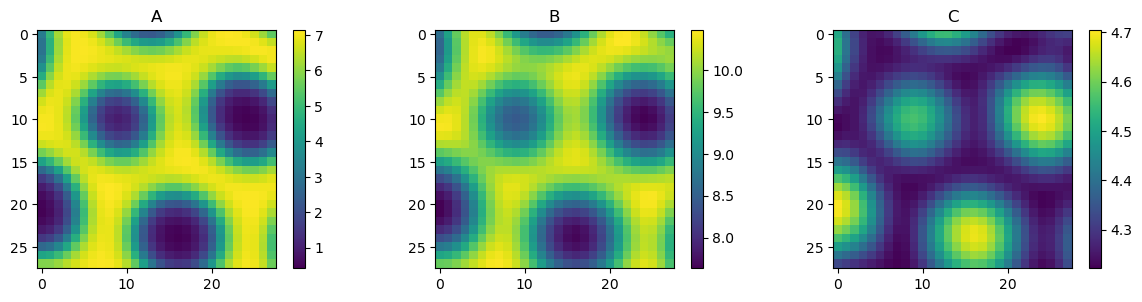

Epoch: 50000 
 data loss:0.044024, 
data A loss:0.029236, data B loss:0.007920, data C loss:0.006868, 
Laplacian A loss:0.071234, Laplacian B loss:0.048890
Physics loss:0.259639
Negative loss:0.000000
Physics A loss:0.029286, 
Physics B loss:0.257506, Physics C loss:0.015668

 b_A=0.0053, b_B=7.9126, b_C=0.0152, V_A=17.7879, V_B=170.4732, V_C=1.0076, mu_A=1.0216, mu_B=5.8711, mu_C=0.0074, K_AA=5.4898, K_AB=5.2511, K_AC=3.4317, K_BA=11.1902, K_BC=1.8469, K_CB=7.4672, K_CC=4.2438, n_AA=3.2982, n_AB=3.4290, n_AC=4.0766, n_BA=5.9578, n_BC=4.1239, n_CB=1.0003, n_CC=3.4649


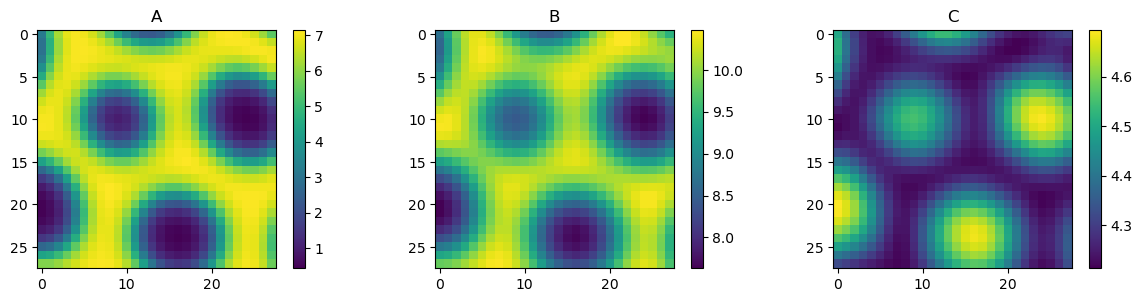

Epoch: 60000 
 data loss:0.043420, 
data A loss:0.029155, data B loss:0.007858, data C loss:0.006408, 
Laplacian A loss:0.063369, Laplacian B loss:0.046671
Physics loss:0.258242
Negative loss:0.000000
Physics A loss:0.029361, 
Physics B loss:0.255808, Physics C loss:0.019725

 b_A=0.0049, b_B=7.8203, b_C=0.0133, V_A=17.8028, V_B=170.2270, V_C=1.0389, mu_A=1.0216, mu_B=5.8595, mu_C=0.0075, K_AA=5.4933, K_AB=5.2500, K_AC=3.6559, K_BA=11.1880, K_BC=1.9605, K_CB=7.4811, K_CC=4.4897, n_AA=3.2962, n_AB=3.4307, n_AC=4.3932, n_BA=5.9709, n_BC=4.3760, n_CB=1.0008, n_CC=3.3779


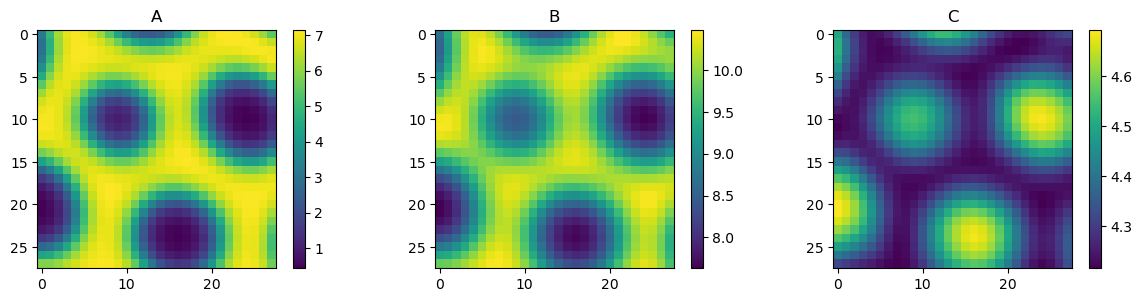

Epoch: 70000 
 data loss:0.042852, 
data A loss:0.029093, data B loss:0.007829, data C loss:0.005930, 
Laplacian A loss:0.057775, Laplacian B loss:0.044839
Physics loss:0.256469
Negative loss:0.000000
Physics A loss:0.029957, 
Physics B loss:0.254417, Physics C loss:0.012281

 b_A=0.0079, b_B=7.7630, b_C=0.0171, V_A=17.8069, V_B=170.0161, V_C=1.0961, mu_A=1.0244, mu_B=5.8525, mu_C=0.0012, K_AA=5.4853, K_AB=5.2494, K_AC=3.8358, K_BA=11.1983, K_BC=2.1079, K_CB=7.4797, K_CC=4.7126, n_AA=3.2967, n_AB=3.4314, n_AC=4.6920, n_BA=5.9169, n_BC=4.5572, n_CB=1.0053, n_CC=3.2960


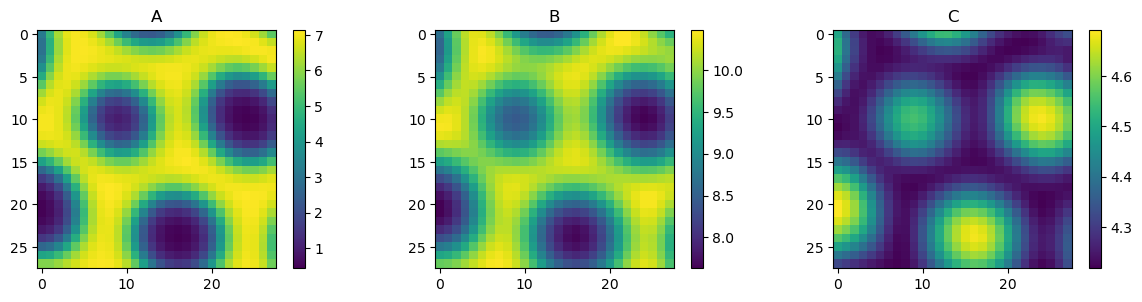

Epoch: 80000 
 data loss:0.042372, 
data A loss:0.029019, data B loss:0.007805, data C loss:0.005548, 
Laplacian A loss:0.053049, Laplacian B loss:0.043198
Physics loss:0.255544
Negative loss:0.000000
Physics A loss:0.029567, 
Physics B loss:0.252639, Physics C loss:0.024542

 b_A=0.0060, b_B=7.7350, b_C=0.0242, V_A=17.8265, V_B=169.8599, V_C=1.1693, mu_A=1.0230, mu_B=5.8489, mu_C=0.0001, K_AA=5.4929, K_AB=5.2494, K_AC=3.9628, K_BA=11.1901, K_BC=2.2710, K_CB=7.4977, K_CC=4.9096, n_AA=3.2943, n_AB=3.4318, n_AC=4.9568, n_BA=5.9535, n_BC=4.6744, n_CB=1.0049, n_CC=3.2335


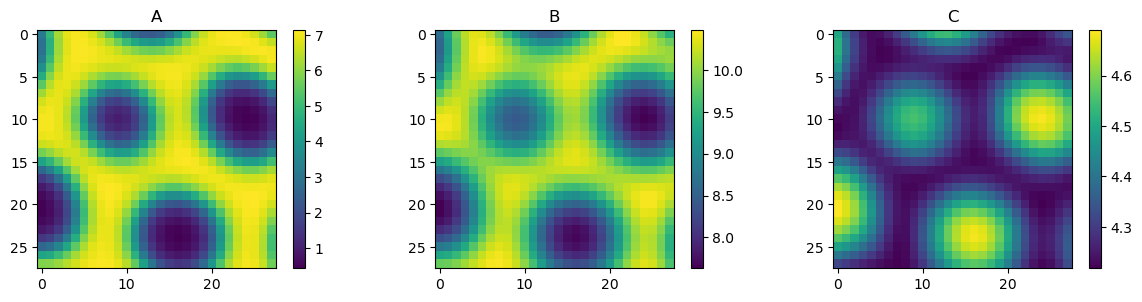

Epoch: 90000 
 data loss:0.042102, 
data A loss:0.028953, data B loss:0.007793, data C loss:0.005357, 
Laplacian A loss:0.049414, Laplacian B loss:0.041869
Physics loss:0.252820
Negative loss:0.000000
Physics A loss:0.029662, 
Physics B loss:0.250700, Physics C loss:0.013691

 b_A=0.0054, b_B=7.7097, b_C=0.0194, V_A=17.8405, V_B=169.7564, V_C=1.2096, mu_A=1.0226, mu_B=5.8458, mu_C=0.0065, K_AA=5.4959, K_AB=5.2495, K_AC=4.1115, K_BA=11.1864, K_BC=2.3833, K_CB=7.5079, K_CC=5.1299, n_AA=3.2930, n_AB=3.4318, n_AC=5.2294, n_BA=5.9640, n_BC=4.8103, n_CB=1.0052, n_CC=3.1722


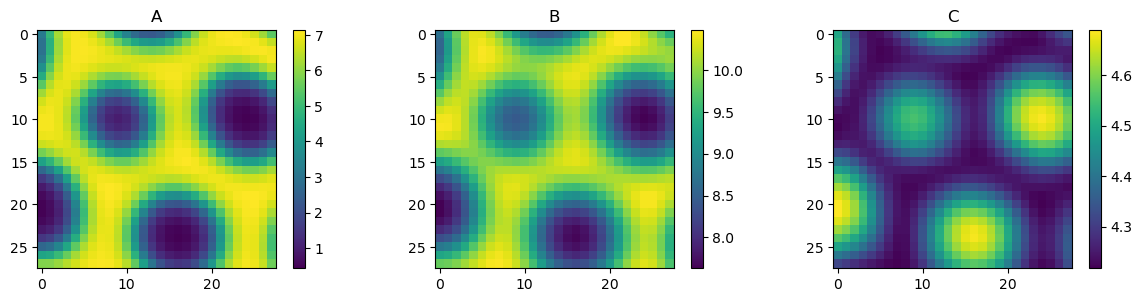

Epoch: 100000 
 data loss:0.041848, 
data A loss:0.028884, data B loss:0.007783, data C loss:0.005182, 
Laplacian A loss:0.046401, Laplacian B loss:0.040731
Physics loss:0.250523
Negative loss:0.000000
Physics A loss:0.029771, 
Physics B loss:0.248745, Physics C loss:0.001110

 b_A=0.0042, b_B=7.6804, b_C=0.0165, V_A=17.8560, V_B=169.6970, V_C=1.2101, mu_A=1.0219, mu_B=5.8422, mu_C=0.0040, K_AA=5.5012, K_AB=5.2496, K_AC=4.1856, K_BA=11.1815, K_BC=2.4319, K_CB=7.5130, K_CC=5.3491, n_AA=3.2908, n_AB=3.4319, n_AC=5.4618, n_BA=5.9879, n_BC=4.9607, n_CB=1.0053, n_CC=3.1446


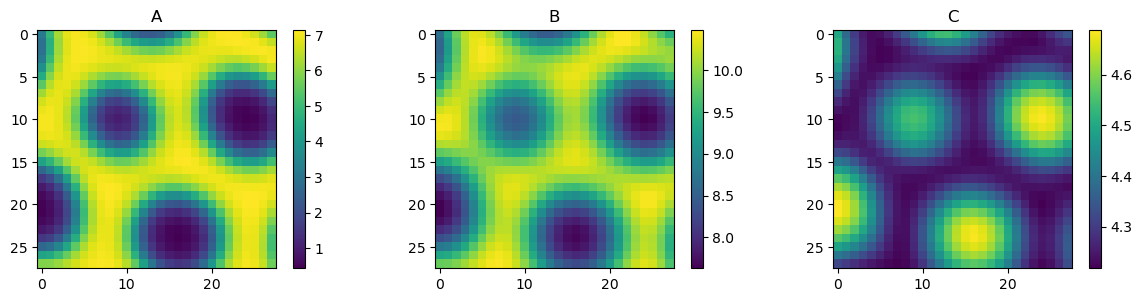

Epoch: 110000 
 data loss:0.041527, 
data A loss:0.028805, data B loss:0.007787, data C loss:0.004934, 
Laplacian A loss:0.067257, Laplacian B loss:0.040188
Physics loss:0.249360
Negative loss:0.000000
Physics A loss:0.030068, 
Physics B loss:0.247540, Physics C loss:0.000146

 b_A=0.0033, b_B=7.6483, b_C=0.0181, V_A=17.8791, V_B=169.6966, V_C=1.2596, mu_A=1.0204, mu_B=5.8380, mu_C=0.0044, K_AA=5.5054, K_AB=5.2499, K_AC=4.2917, K_BA=11.1748, K_BC=2.5521, K_CB=7.5344, K_CC=5.5441, n_AA=3.2898, n_AB=3.4319, n_AC=5.7005, n_BA=6.0000, n_BC=5.0350, n_CB=1.0005, n_CC=3.1145


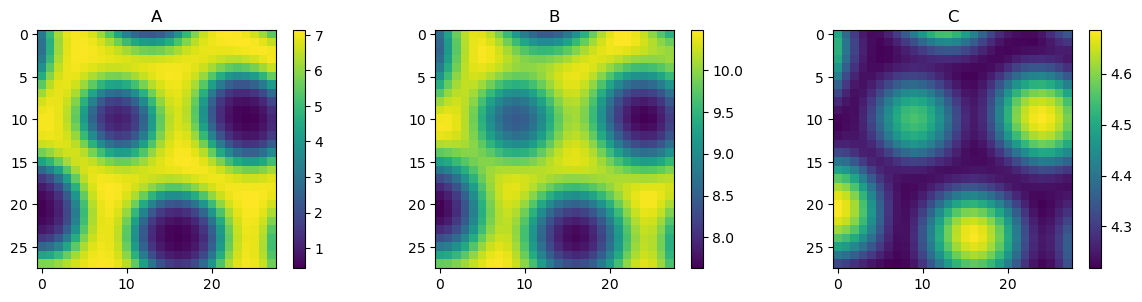

Epoch: 120000 
 data loss:0.041940, 
data A loss:0.028741, data B loss:0.007949, data C loss:0.005250, 
Laplacian A loss:0.077291, Laplacian B loss:0.043395
Physics loss:0.298252
Negative loss:0.000000
Physics A loss:0.034627, 
Physics B loss:0.296218, Physics C loss:0.003256

 b_A=0.0052, b_B=7.6244, b_C=0.0185, V_A=17.8916, V_B=169.7378, V_C=1.2867, mu_A=1.0189, mu_B=5.8319, mu_C=0.0046, K_AA=5.5046, K_AB=5.2485, K_AC=4.3496, K_BA=11.1768, K_BC=2.6323, K_CB=7.5430, K_CC=5.7327, n_AA=3.2901, n_AB=3.4322, n_AC=5.9118, n_BA=6.0000, n_BC=5.1137, n_CB=1.0066, n_CC=3.1092


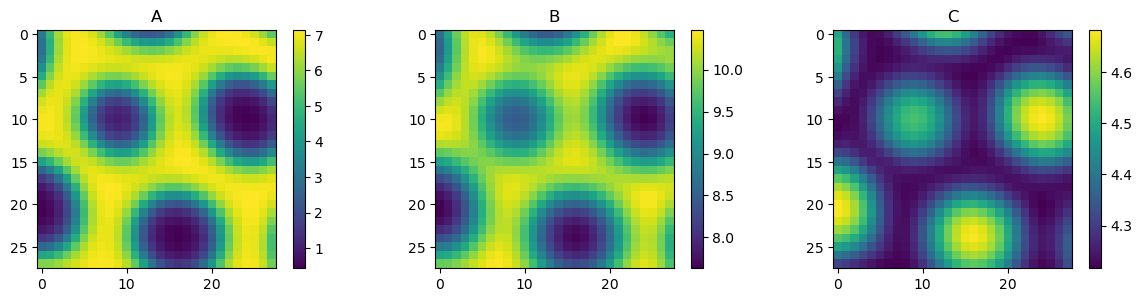

Epoch: 130000 
 data loss:0.041575, 
data A loss:0.028866, data B loss:0.007988, data C loss:0.004721, 
Laplacian A loss:0.065427, Laplacian B loss:0.040749
Physics loss:0.280812
Negative loss:0.000000
Physics A loss:0.039818, 
Physics B loss:0.277939, Physics C loss:0.004453

 b_A=0.0001, b_B=7.5575, b_C=0.0164, V_A=17.8554, V_B=169.9063, V_C=1.2828, mu_A=1.0223, mu_B=5.8297, mu_C=0.0029, K_AA=5.5073, K_AB=5.2526, K_AC=4.4112, K_BA=11.1810, K_BC=2.6629, K_CB=7.4846, K_CC=5.9282, n_AA=3.2844, n_AB=3.4289, n_AC=6.0000, n_BA=5.9856, n_BC=5.2115, n_CB=1.0045, n_CC=3.1144


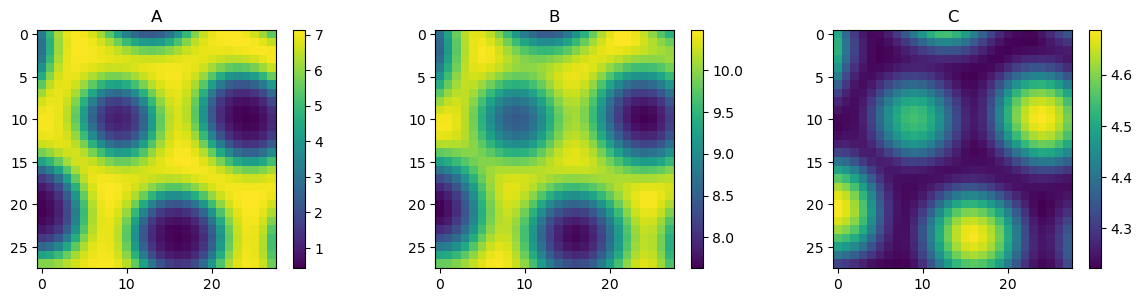

Epoch: 140000 
 data loss:0.040518, 
data A loss:0.028507, data B loss:0.007766, data C loss:0.004245, 
Laplacian A loss:0.058763, Laplacian B loss:0.037823
Physics loss:0.245361
Negative loss:0.000000
Physics A loss:0.031605, 
Physics B loss:0.243298, Physics C loss:0.003021

 b_A=0.0017, b_B=7.5157, b_C=0.0216, V_A=17.8702, V_B=170.2055, V_C=1.3466, mu_A=1.0194, mu_B=5.8213, mu_C=0.0043, K_AA=5.5046, K_AB=5.2495, K_AC=4.4528, K_BA=11.1839, K_BC=2.7974, K_CB=7.4441, K_CC=6.0845, n_AA=3.2854, n_AB=3.4322, n_AC=6.0000, n_BA=5.9892, n_BC=5.2111, n_CB=1.0076, n_CC=3.1155


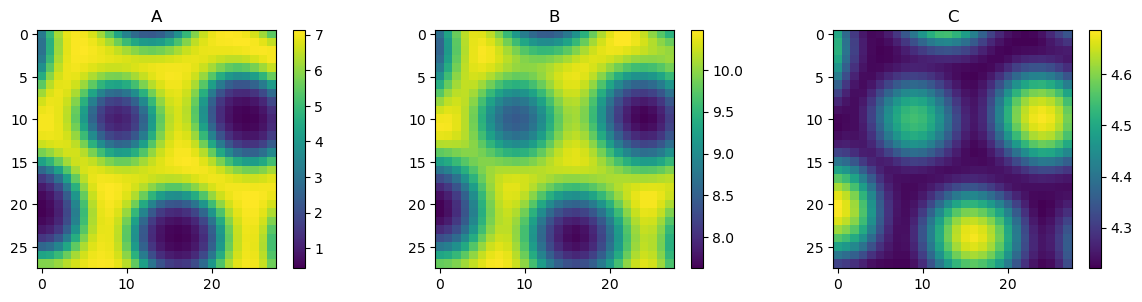

Epoch: 150000 
 data loss:0.040425, 
data A loss:0.028453, data B loss:0.007844, data C loss:0.004128, 
Laplacian A loss:0.047121, Laplacian B loss:0.037400
Physics loss:0.246573
Negative loss:0.000000
Physics A loss:0.030767, 
Physics B loss:0.244645, Physics C loss:0.000459

 b_A=0.0028, b_B=7.4833, b_C=0.0210, V_A=17.8898, V_B=170.5597, V_C=1.3549, mu_A=1.0207, mu_B=5.8192, mu_C=0.0054, K_AA=5.5071, K_AB=5.2516, K_AC=4.4765, K_BA=11.1775, K_BC=2.8409, K_CB=7.3932, K_CC=6.2629, n_AA=3.2862, n_AB=3.4298, n_AC=6.0000, n_BA=5.9995, n_BC=5.2654, n_CB=1.0059, n_CC=3.1408


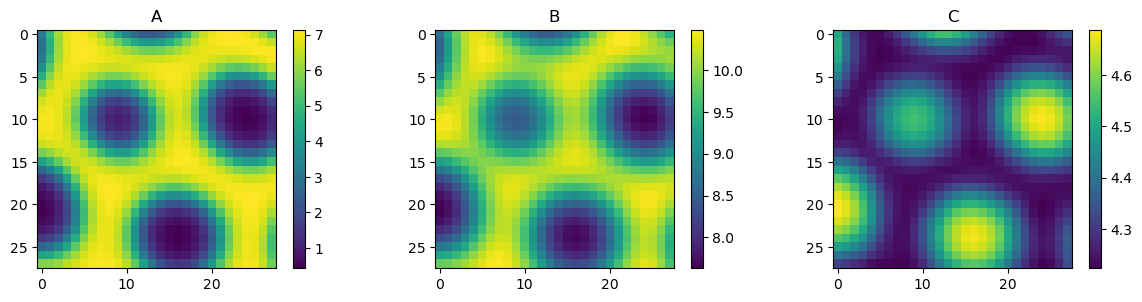

Epoch: 160000 
 data loss:0.040146, 
data A loss:0.028337, data B loss:0.007862, data C loss:0.003947, 
Laplacian A loss:0.057079, Laplacian B loss:0.037747
Physics loss:0.242584
Negative loss:0.000000
Physics A loss:0.031509, 
Physics B loss:0.239370, Physics C loss:0.023581

 b_A=0.0033, b_B=7.4503, b_C=0.0236, V_A=17.8988, V_B=170.9795, V_C=1.3550, mu_A=1.0213, mu_B=5.8144, mu_C=0.0002, K_AA=5.5077, K_AB=5.2507, K_AC=4.5021, K_BA=11.1780, K_BC=2.8719, K_CB=7.3277, K_CC=6.4430, n_AA=3.2855, n_AB=3.4305, n_AC=5.9999, n_BA=6.0000, n_BC=5.3105, n_CB=1.0102, n_CC=3.1803


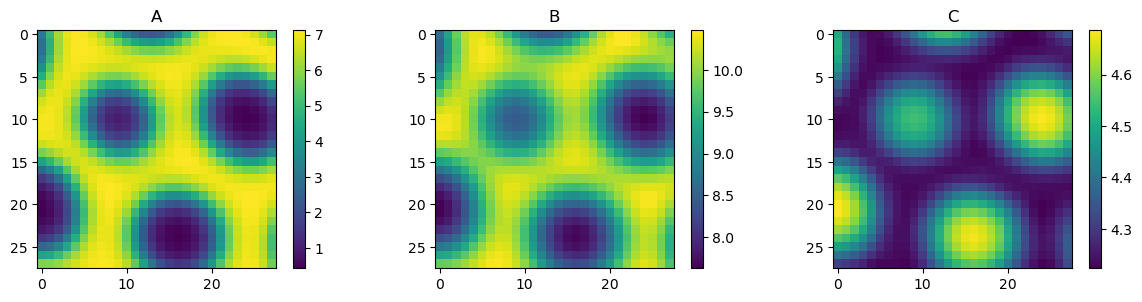

Epoch: 170000 
 data loss:0.039861, 
data A loss:0.028282, data B loss:0.007771, data C loss:0.003809, 
Laplacian A loss:0.037376, Laplacian B loss:0.035289
Physics loss:0.240176
Negative loss:0.000000
Physics A loss:0.031454, 
Physics B loss:0.238015, Physics C loss:0.006625

 b_A=0.0030, b_B=7.4215, b_C=0.0229, V_A=17.9025, V_B=171.4677, V_C=1.3818, mu_A=1.0230, mu_B=5.8113, mu_C=0.0043, K_AA=5.5079, K_AB=5.2505, K_AC=4.5156, K_BA=11.1777, K_BC=2.9392, K_CB=7.2665, K_CC=6.5955, n_AA=3.2852, n_AB=3.4308, n_AC=6.0000, n_BA=5.9939, n_BC=5.3173, n_CB=1.0101, n_CC=3.2086


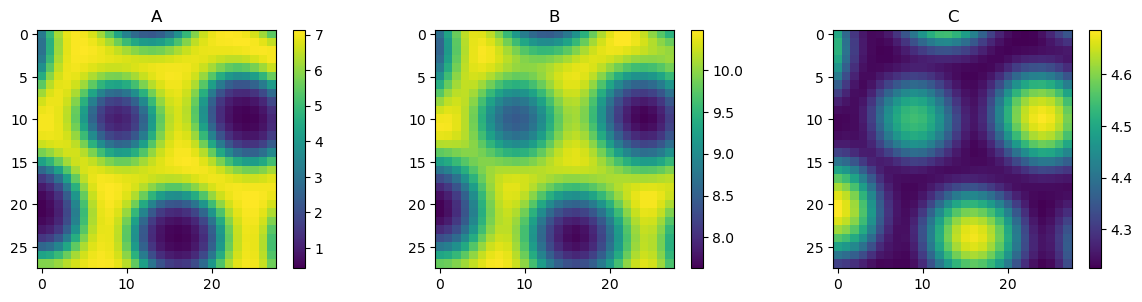

Epoch: 180000 
 data loss:0.039624, 
data A loss:0.028092, data B loss:0.007801, data C loss:0.003732, 
Laplacian A loss:0.050216, Laplacian B loss:0.035302
Physics loss:0.242546
Negative loss:0.000000
Physics A loss:0.033106, 
Physics B loss:0.239349, Physics C loss:0.021095

 b_A=0.0045, b_B=7.3951, b_C=0.0228, V_A=17.9133, V_B=172.0172, V_C=1.3534, mu_A=1.0216, mu_B=5.8063, mu_C=0.0005, K_AA=5.5067, K_AB=5.2491, K_AC=4.5280, K_BA=11.1787, K_BC=2.9211, K_CB=7.1885, K_CC=6.7823, n_AA=3.2855, n_AB=3.4317, n_AC=6.0000, n_BA=5.9963, n_BC=5.3690, n_CB=1.0155, n_CC=3.2918


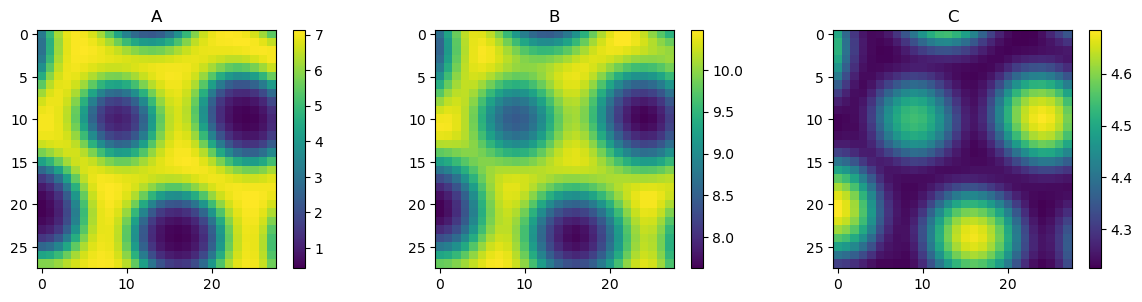

Epoch: 190000 
 data loss:0.039435, 
data A loss:0.028062, data B loss:0.007732, data C loss:0.003641, 
Laplacian A loss:0.041186, Laplacian B loss:0.034454
Physics loss:0.235963
Negative loss:0.000000
Physics A loss:0.031443, 
Physics B loss:0.233836, Physics C loss:0.003291

 b_A=0.0026, b_B=7.3795, b_C=0.0187, V_A=17.9214, V_B=172.5953, V_C=1.3851, mu_A=1.0221, mu_B=5.8053, mu_C=0.0052, K_AA=5.5101, K_AB=5.2494, K_AC=4.5406, K_BA=11.1741, K_BC=2.9961, K_CB=7.0922, K_CC=6.9252, n_AA=3.2838, n_AB=3.4308, n_AC=6.0000, n_BA=6.0000, n_BC=5.3474, n_CB=1.0237, n_CC=3.3397


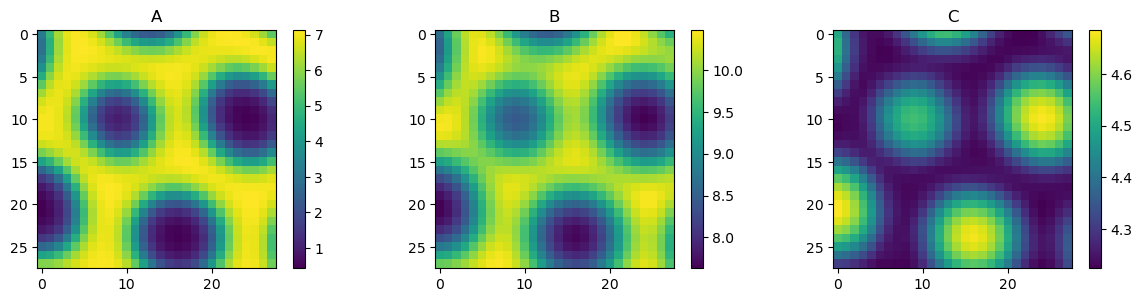

Epoch: 200000 
 data loss:0.039321, 
data A loss:0.027961, data B loss:0.007750, data C loss:0.003609, 
Laplacian A loss:0.033621, Laplacian B loss:0.033614
Physics loss:0.233965
Negative loss:0.000000
Physics A loss:0.031550, 
Physics B loss:0.231562, Physics C loss:0.011107

 b_A=0.0026, b_B=7.3667, b_C=0.0225, V_A=17.9217, V_B=173.1833, V_C=1.4090, mu_A=1.0220, mu_B=5.8040, mu_C=0.0027, K_AA=5.5100, K_AB=5.2483, K_AC=4.5456, K_BA=11.1738, K_BC=3.0569, K_CB=6.9662, K_CC=7.0708, n_AA=3.2840, n_AB=3.4303, n_AC=6.0000, n_BA=6.0000, n_BC=5.3238, n_CB=1.0406, n_CC=3.4076


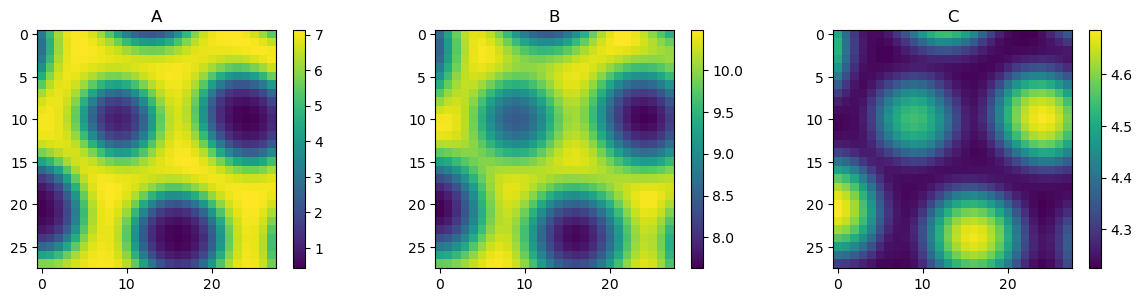

    Early dtoped at 200037
Epoch: 200037 
 data loss:0.039308, 
data A loss:0.027957, data B loss:0.007741, data C loss:0.003610, 
Laplacian A loss:0.033489, Laplacian B loss:0.033676
Physics loss:0.233698
Negative loss:0.000000
Physics A loss:0.031549, 
Physics B loss:0.231496, Physics C loss:0.005380

 b_A=0.0024, b_B=7.3690, b_C=0.0194, V_A=17.9234, V_B=173.1842, V_C=1.4050, mu_A=1.0218, mu_B=5.8043, mu_C=0.0052, K_AA=5.5102, K_AB=5.2484, K_AC=4.5444, K_BA=11.1723, K_BC=3.0510, K_CB=6.9679, K_CC=7.0744, n_AA=3.2842, n_AB=3.4303, n_AC=6.0000, n_BA=6.0003, n_BC=5.3287, n_CB=1.0402, n_CC=3.4106


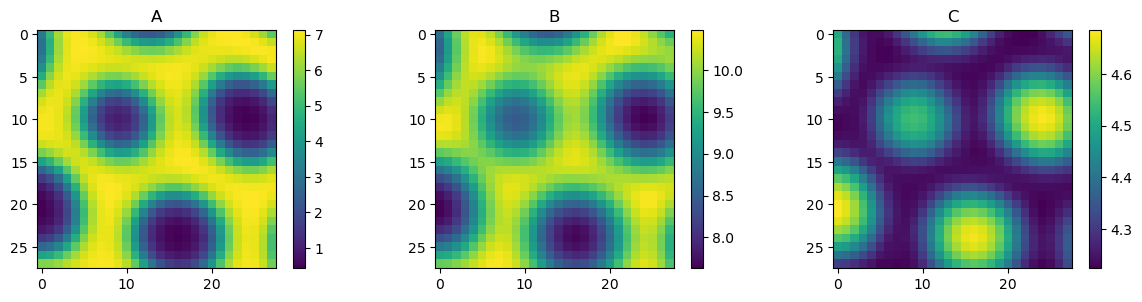

In [7]:
torch.manual_seed(42)
np.random.seed(42)
dtype = torch.float32
torch.set_default_dtype(dtype)

def create_var(init=None):
    if init is None:
        return torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str)), []
    else:
        return torch.nn.Parameter(init*torch.ones(1, requires_grad=True, device=dev_str)), []


D_A = params["D_A"]#, sampled_D_A = create_var(1)
D_B = params["D_B"]#, sampled_D_B = create_var(1)
b_A, sampled_b_A = create_var(1)
b_B, sampled_b_B = create_var(1)
b_C, sampled_b_C = create_var(1)
V_A, sampled_V_A = create_var(1)
V_B, sampled_V_B = create_var(1)
V_C, sampled_V_C = create_var(1)
mu_A, sampled_mu_A = create_var(1)
mu_B, sampled_mu_B = create_var(1)
mu_C, sampled_mu_C = create_var(1)
K_AA, sampled_K_AA = create_var(1)#K_AA_init)
K_AB, sampled_K_AB = create_var(1)#K_AB_init)
K_AC, sampled_K_AC = create_var(1)#K_AC_init)
K_BA, sampled_K_BA = create_var(1)#K_BA_init)
K_BC, sampled_K_BC = create_var(1)#K_BC_init)
K_CB, sampled_K_CB = create_var(1)#K_CB_init)
K_CC, sampled_K_CC = create_var(1)#K_CC_init)
n_AA, sampled_n_AA = create_var(2)#= params['n']
n_AB, sampled_n_AB = create_var(2)#= params['n']
n_AC, sampled_n_AC = create_var(2)#= params['n']
n_BA, sampled_n_BA = create_var(2)#= params['n']
n_BC, sampled_n_BC = create_var(2)#= params['n']
n_CB, sampled_n_CB = create_var(2)#= params['n']
n_CC, sampled_n_CC = create_var(2)#= params['n']

params_name_list = [#"D_A", #"D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", "mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", 
                    "K_CC", 
                     "n_AA", "n_AB", "n_AC",
                     "n_BA", "n_BC",
                     "n_CB", "n_CC",
]

params_list = [#D_A, #D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC, 
               n_AA, n_AB, n_AC, n_BA, n_BC,
               n_CB, n_CC
]

params_sampled_list =[#sampled_D_A, #sampled_D_B,
                      sampled_b_A, sampled_b_B, sampled_b_C, sampled_V_A, sampled_V_B, sampled_V_C,
                      sampled_mu_A, sampled_mu_B, sampled_mu_C,
                      sampled_K_AA, sampled_K_AB, sampled_K_AC, sampled_K_BA, sampled_K_BC,
                      sampled_K_CB, sampled_K_CC,
                      sampled_n_AA, sampled_n_AB, sampled_n_AC,
                      sampled_n_BA, sampled_n_BC, 
                      sampled_n_CB, sampled_n_CC,
                     ]

###########################################################
# Inputs
# restrict to inner boundaries
x = torch.linspace(0, run_params.Lx, run_params.Ix)[x_slice].to(device)
y = torch.linspace(0, run_params.Ly, run_params.Jy)[y_slice].to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

def transform(x, l, u):
    return (u-l)*x + l

x2 = transform(torch.rand(run_params.Ix),torch.min(x).item(),torch.max(x).item())
y2 = transform(torch.rand(run_params.Jy),torch.min(y).item(),torch.max(y).item())
X2,Y2 = torch.meshgrid(x2, y2, indexing='ij')
physics_X = torch.vstack([X2.flatten(), Y2.flatten()]).T.requires_grad_(True).to(device)
##########################################################
#   Data
# restrict to inner boundaries
data_A = torch.from_numpy(A_n[x_slice,y_slice].flatten()).to(device)
data_B = torch.from_numpy(B_n[x_slice,y_slice].flatten()).to(device)
data_C = torch.from_numpy(C_n[x_slice,y_slice].flatten()).to(device)
###########################################################
# Laplacians
# First, find the finite-diff Laplacian on the whole domain,
# then, select the inner boundaries. This way, the boundaries 
# effets removed
diffusion_scale_factor = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
laplacianA = diffusion_scale_factor * grad_diff(A_n)
laplacianB = diffusion_scale_factor * grad_diff(B_n)

laplacianA = torch.tensor(laplacianA[x_slice,y_slice].flatten()).to(device)
laplacianB = torch.tensor(laplacianB[x_slice,y_slice].flatten()).to(device)
###########################################################
zeors_tensor = torch.zeros(data_X.shape[0]).to(device)
###########################################################
# Model
lb = torch.tensor([torch.min(x).item(), torch.min(y).item()]).to(device)
ub = torch.tensor([torch.max(x).item(), torch.max(y).item()]).to(device)
model = Net_sep_dense_normalised(2,3,[128,128,128,128], lb, ub).to(device)
###########################################################
# optimizer
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 1e-4},
                              {'params': params_list, 'lr': .1},
                              #{'params': [n], 'lr': 0.5}
                             ]
                              , lr=1e-4)#.LBFGS([*model.parameters(), *params_list], lr=1
                             #,line_search_fn='strong_wolfe')#


epochs = 200000
loss_data = 0.0
lambda_data = 1.0
loss_physics = 0.0
lambda_physics = 1e-3
loss_laplacian_physics = 0.0
lambda_physics_laplacian = 1e-2
loss_negative = 0
lambda_negative = 100

losses = np.zeros((10, epochs + 6000))
last_loss = np.inf

negative_threshold = nn.Threshold(0.0, 0.0)

def act_t(x, km, n=2):
    return negative_threshold(x)**n / (negative_threshold(x)**n + km**n)

def inh_t(x, km, n=2):
    return km**n / (negative_threshold(x)**n + km**n)

for i in range(epochs + 6000): 
    # L-BFGS
    def closure():
        
        optimizer.zero_grad()

        #################################
        # data loss
        data_f_hat = model(data_X)
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        loss_A_data = torch.mean((data_A - data_A_hat)**2)
        loss_B_data = torch.mean((data_B - data_B_hat)**2)
        loss_C_data = torch.mean((data_C - data_C_hat)**2)
        loss_data = (loss_A_data + loss_B_data + loss_C_data)/3
        #################################
        loss_negative = torch.mean(torch.maximum(-data_A_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_B_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_C_hat, zeors_tensor)**2
                       )
        #################################
        # Laplacians derivatives        
        laplacianA_hat = Laplacian(data_A_hat, data_X)
        laplacianB_hat = Laplacian(data_B_hat, data_X)
        
        A_loss_laplacian = torch.mean((laplacianA_hat-laplacianA)**2)
        B_loss_laplacian = torch.mean((laplacianB_hat-laplacianB)**2)
        loss_laplacian_physics = A_loss_laplacian + B_loss_laplacian
        ###############################
        # physics derivatives  
        physics_f_hat = model(physics_X)
        A = physics_f_hat[0].squeeze() 
        B = physics_f_hat[1].squeeze() 
        C = physics_f_hat[2].squeeze() 
        
        laplacianA_hat = Laplacian(A, physics_X)
        laplacianB_hat = Laplacian(B, physics_X)
        
        F_A =  b_A + V_A*act_t(A, K_AA, n_AA)*inh_t(B, K_BA, n_BA) - mu_A * A     
        F_B =  b_B + V_B*act_t(A, K_AB, n_AB)*inh_t(C, K_CB, n_CB) - mu_B * B        
        F_C =  b_C + V_C*inh_t(A, K_AC, n_AC)*inh_t(B, K_BC, n_BC)*act_t(C, K_CC, n_CC) - mu_C * C        

        dAdt = D_A * laplacianA_hat + F_A
        dBdt = D_B * laplacianB_hat + F_B
        dCdt = F_C
        ################################
        # physics loss
        # Construct the physics loss here
        A_loss_physics = torch.mean(dAdt**2)
        B_loss_physics = torch.mean(dBdt**2)
        C_loss_physics = torch.mean(dCdt**2)
        loss_physics = (A_loss_physics 
                        + B_loss_physics 
                        + C_loss_physics)
        ###############################
        total_loss = (
            +lambda_data*loss_data            
            +lambda_physics_laplacian*loss_laplacian_physics
            +lambda_physics*loss_physics
            #+lambda_negative*loss_negative
                        )

        total_loss.backward(retain_graph=True)
        
        
        losses[:,i] = (loss_A_data.item(), loss_B_data.item(), loss_C_data.item(), 
                       A_loss_laplacian.item(), B_loss_laplacian.item(),
                       loss_physics.item(), loss_negative.item(),
                       A_loss_physics.item(),   
                       B_loss_physics.item(), 
                       C_loss_physics.item())                    
            
        return total_loss
    
    
    
    optimizer.step(closure)
    
    def show_outputs(i):
        ls = np.sqrt(losses[:, i])
        print("============================================")
        print(f"Epoch: {i+1} \n data loss:{np.sum(ls[0:3]):.6f}, \n"
              f"data A loss:{ls[0]:.6f}, data B loss:{ls[1]:.6f}, data C loss:{ls[2]:.6f}, \n"
              f"Laplacian A loss:{ls[3]:.6f}, Laplacian B loss:{ls[4]:.6f}\n"
              f"Physics loss:{ls[5]:.6f}\n"
              f"Negative loss:{ls[6]:.6f}\n"
              f"Physics A loss:{ls[7]:.6f}, \nPhysics B loss:{ls[8]:.6f}, "
              f"Physics C loss:{ls[9]:.6f}\n"
              f"\n"
              ,
              ", ".join([f"{name}={param.item():.4f}" for param, name in zip(params_list, params_name_list)])
             )
        data_f_hat = model(data_X)        
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        plot_n_im([to(data_A_hat.cpu().detach().numpy()), 
                   to(data_B_hat.cpu().detach().numpy()), 
                   to(data_C_hat.cpu().detach().numpy())], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show()
       
    
    if i < epochs and last_loss > np.sum(losses[:,i]):
        last_loss =  np.sum(losses[:,i])
            
    elif np.sum(losses[:,i]) < last_loss:
        print("============================================")
        print(f"    Early dtoped at {i+1}")
        print("============================================")
        show_outputs(i)
        early_stop = True
        with torch.no_grad():
            for i,(param, name) in enumerate(zip(params_list, params_name_list)):
                l,u = get_bound(name)
                param[:] = param.clamp(l,u)
                params_sampled_list[i].append(param.item())
        break        
    
    
        
    with torch.no_grad():
        for j,(param, name) in enumerate(zip(params_list, params_name_list)):
            l,u = get_bound(name)
            param[:] = param.clamp(l,u)
            params_sampled_list[j].append(param.item())
#         ####################
#         # Make sure the Node A
#         # parameters are not all 
#         # zero
#         l_A = 1
#         c_D_A = 5e3
#         c_b_A = 1e1
#         c_V_A = 1e0
#         c_mu_A = 1e1
#         c_A_2 = c_D_A**2 + c_b_A**2 +  c_V_A**2 + c_mu_A**2
#         def A_bound(x1, x2, x3, x4):
#             return l_A - c_D_A * x1 - c_b_A * x2 - c_V_A * x3 - c_mu_A * x4       
#         shift = A_bound(D_A.item(), b_A.item(), V_A.item(), mu_A.item())
#         if shift > 0:
#             D_A[:] = c_D_A*shift/c_A_2 + D_A.item()
#             if D_A.item() < D_A_bound[0]:
#                 D_A[:] = D_A_bound[0]
#             b_A[:] = c_b_A*shift/c_A_2 + b_A.item()
#             V_A[:] = c_V_A*shift/c_A_2 + V_A.item()
#             mu_A[:] = c_mu_A*shift/c_A_2 + mu_A.item() 
#         ####################
#         # Make sure the Node B
#         # parameters are not all 
#         # zero
#         l_B = 1
#         c_D_B = 5e3
#         c_b_B = 1e1
#         c_V_B = 1e0
#         c_mu_B = 1e1
#         c_B_2 = c_D_B**2 + c_b_B**2 +  c_V_B**2 + c_mu_B**2
#         def B_bound(x1, x2, x3, x4):
#             return l_B - c_D_B * x1 - c_b_B * x2 - c_V_B * x3 - c_mu_B * x4        
#         shift = B_bound(D_B.item(), b_B.item(), V_B.item(), mu_B.item())
#         if shift > 0:
#             D_B[:] = c_D_B*shift/c_B_2 + D_B.item()
#             b_B[:] = c_b_B*shift/c_B_2 + b_B.item()
#             V_B[:] = c_V_B*shift/c_B_2 + V_B.item()
#             mu_B[:] = c_mu_B*shift/c_B_2 + mu_B.item()  
        ####################
        # Make sure the Node C
        # parameters are not all 
        # zero
        l_C = 1
        c_b_C = 1e1
        c_V_C = 1e0
        c_mu_C = 1e1
        c_C_2 = c_b_C**2 +  c_V_C**2 + c_mu_C**2
        def C_bound(x1, x2, x3):
            return l_C - c_b_C * x1 - c_V_C * x2 - c_mu_C * x3
        
        shift = C_bound(b_C.item(), V_C.item(), mu_C.item())
        if shift > 0:
            b_C[:] = c_b_C*shift/c_C_2 + b_C.item()
            V_C[:] = c_V_C*shift/c_C_2 + V_C.item()
            mu_C[:] = c_mu_C*shift/c_C_2 + mu_C.item()     
            
    if (i+1)%10000 == 0 or i==0:        
        show_outputs(i)
                
            


# Plot the trained outputs

A RMSE:0.027954169764139322 B RMSE:0.007741245931161774 C RMSE:0.00361010464861658
F_A actual:0.9072123787570736, F_A:0.9050644636154175, RMSE: 0.01713520718739618
F_B actual:715.9707289852231, F_B:707.9194946289062, RMSE: 0.28952962875088295
F_C actual:4.464229024647136e-06, F_C:0.00021779738017357886, RMSE: 0.014614181587888273

Laplacian A RMSE: 0.03357233717408914
Laplacian B RMSE: 0.03367891155129368

dAdt RMSE: 0.01708911466626415
dBdt RMSE: 0.28981401411882357
dCdt RMSE: 0.014614181587888273


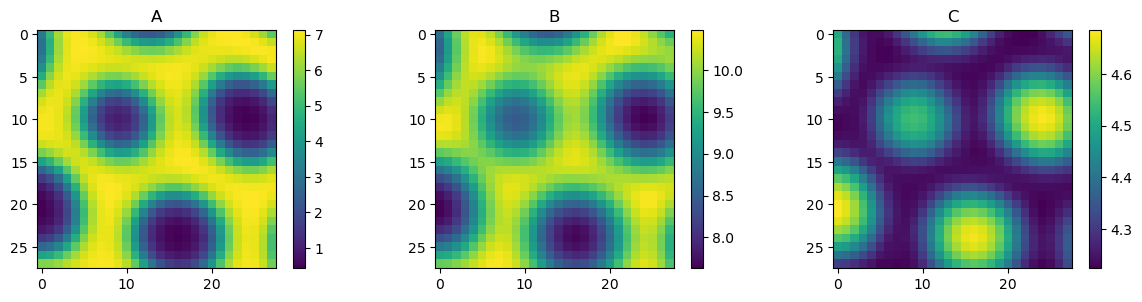

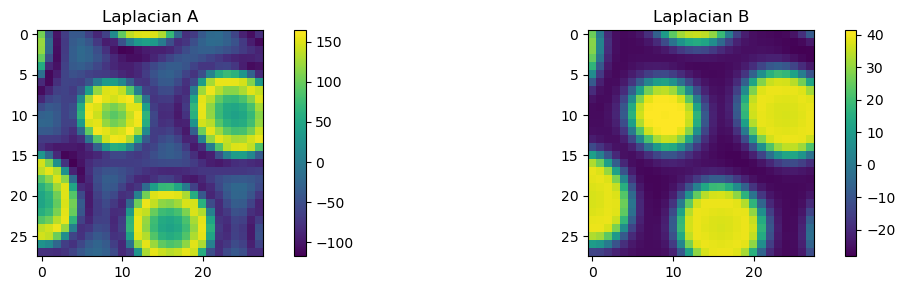

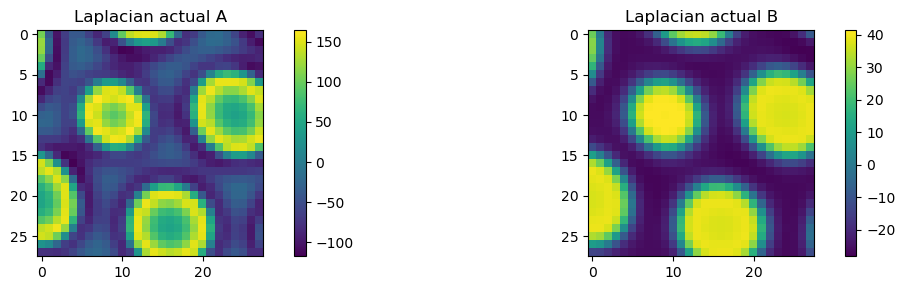

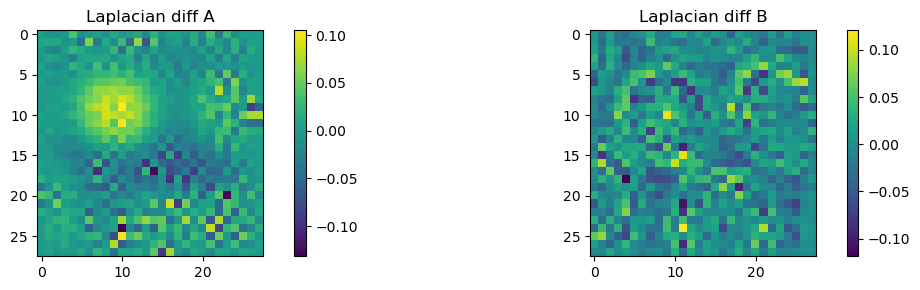

In [8]:
def act(x, km, n=2):
    return x**n / (x**n + km**n)

def inh(x, km, n=2):
    return km**n / (x**n + km**n)

physics_f = model(data_X)
A_hat = physics_f[0].squeeze()
B_hat = physics_f[1].squeeze()
C_hat = physics_f[2].squeeze()

laplacianA_hat = Laplacian(A_hat, data_X)
laplacianB_hat = Laplacian(B_hat, data_X)

A_hat = to(A_hat.cpu().detach().numpy())
B_hat = to(B_hat.cpu().detach().numpy())
C_hat = to(C_hat.cpu().detach().numpy())
laplacianA_hat = to(laplacianA_hat.cpu().detach().numpy())
laplacianB_hat = to(laplacianB_hat.cpu().detach().numpy())


laplacianA = diffusion_scale_factor * grad_diff(A_n)[x_slice,y_slice]
laplacianB = diffusion_scale_factor * grad_diff(B_n)[x_slice,y_slice]

n = params["n"]

A = A_n[x_slice,y_slice]
B = B_n[x_slice,y_slice]
C = C_n[x_slice,y_slice]

F_A =  params["b_A"] + params["V_A"]*act(A, params["K_AA"], n)*inh(B, params["K_BA"], n) - params["mu_A"] * A
F_A_hat =  params["b_A"] + params["V_A"]*act(A_hat, params["K_AA"], n)*inh(B_hat, params["K_BA"], n) - params["mu_A"] * A_hat
F_B =  params["b_B"] + params["V_B"]*act(A, params["K_AB"], n)*inh(C, params["K_CB"], n) - params["mu_B"] * B
F_B_hat =  params["b_B"] + params["V_B"]*act(A_hat, params["K_AB"], n)*inh(C_hat, params["K_CB"], n) - params["mu_B"] * B_hat
F_C =  params["b_C"] + params["V_C"]*inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n) - params["mu_C"] * C
F_C_hat =  params["b_C"] + params["V_C"]*inh(A_hat, params["K_AC"], n)*inh(B_hat, params["K_BC"], n)*act(C_hat, params["K_CC"], n) - params["mu_C"] * C_hat


dAdt = params["D_A"]*laplacianA + F_A
dAdt_hat = params["D_A"]*laplacianA_hat + F_A_hat
dBdt = params["D_B"]*laplacianB + F_B
dBdt_hat = params["D_B"]*laplacianB_hat + F_B_hat

print(f"A RMSE:{np.sqrt(np.mean((A_hat-A)**2))}",
      f"B RMSE:{np.sqrt(np.mean((B_hat-B)**2))}",
      f"C RMSE:{np.sqrt(np.mean((C_hat-C)**2))}")

print(f"F_A actual:{np.mean(F_A**2)}, F_A:{np.mean(F_A_hat**2)}, RMSE: {np.sqrt(np.mean((F_A - F_A_hat)**2))}")
print(f"F_B actual:{np.mean(F_B**2)}, F_B:{np.mean(F_B_hat**2)}, RMSE: {np.sqrt(np.mean((F_B - F_B_hat)**2))}")
print(f"F_C actual:{np.mean(F_C**2)}, F_C:{np.mean(F_C_hat**2)}, RMSE: {np.sqrt(np.mean((F_C - F_C_hat)**2))}")
      

print()
print(f"Laplacian A RMSE: {np.sqrt(np.mean((laplacianA_hat-laplacianA)**2))}")
print(f"Laplacian B RMSE: {np.sqrt(np.mean((laplacianB_hat-laplacianB)**2))}")

print()
print(f"dAdt RMSE: {np.sqrt(np.mean((dAdt-dAdt_hat)**2))}")
print(f"dBdt RMSE: {np.sqrt(np.mean((dBdt-dBdt_hat)**2))}")
print(f"dCdt RMSE: {np.sqrt(np.mean((F_C-F_C_hat)**2))}")

plot_n_im([A_hat, B_hat, C_hat], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()


plot_n_im([laplacianA_hat, laplacianB_hat], 
          ["Laplacian A", "Laplacian B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA, laplacianB], 
          ["Laplacian actual A", "Laplacian actual B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA_hat-laplacianA, laplacianB_hat-laplacianB], 
          ["Laplacian diff A", "Laplacian diff B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()



# Plot losses

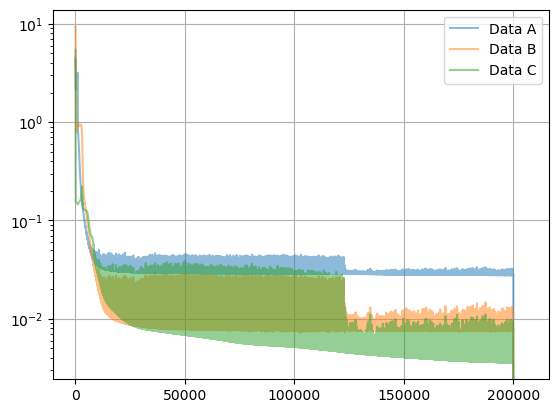

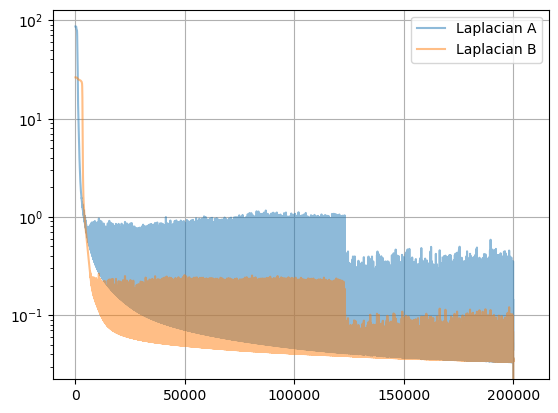

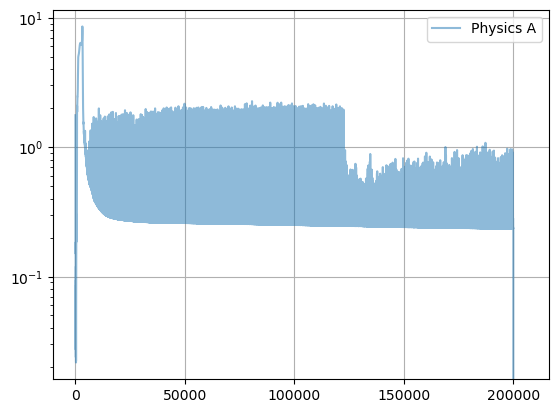

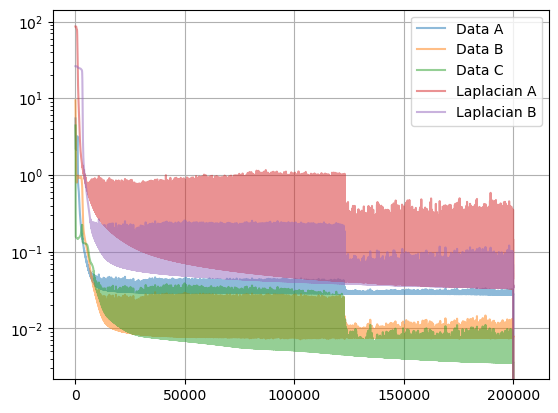

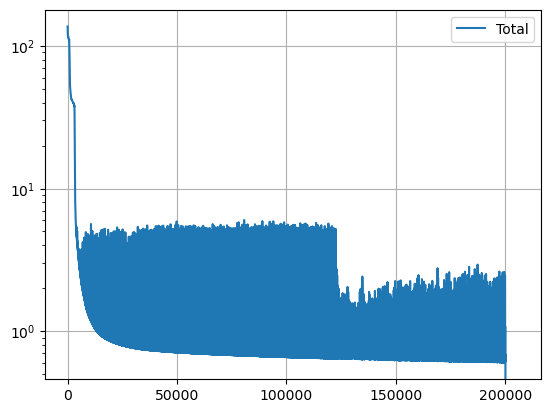

In [9]:
ls= np.sqrt(losses)
plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(ls[5,:], alpha=.5, label="Physics A")
plt.yscale('log');plt.grid();plt.legend();plt.show()


plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log'); plt.grid();plt.legend();plt.show()

plt.plot(np.sum(ls, axis=0), label="Total")
plt.yscale('log'); plt.grid();plt.legend();plt.show()


# Plot the trained Field and its difference

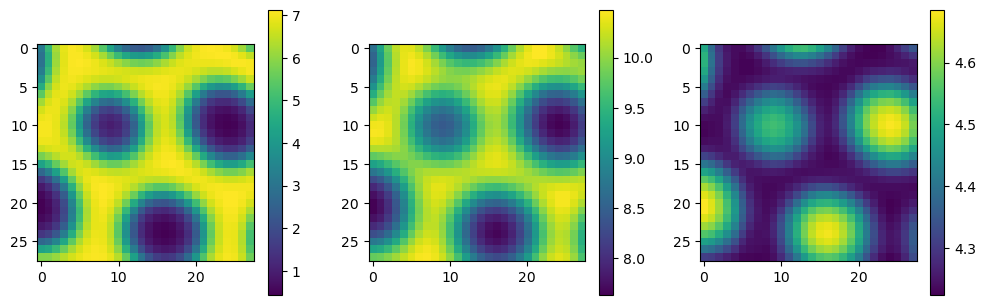

In [10]:
solution_hat = model(data_X)
A_hat = to(solution_hat[0].cpu().detach().numpy())
B_hat = to(solution_hat[1].cpu().detach().numpy())
C_hat = to(solution_hat[2].cpu().detach().numpy())
_ = plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(A_hat)
plt.colorbar(shrink=.5)
plt.subplot(132)
plt.imshow(B_hat)
plt.colorbar(shrink=.5)
plt.subplot(133)
plt.imshow(C_hat)
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

0.027954169764139322
0.007741245931161774
0.00361010464861658


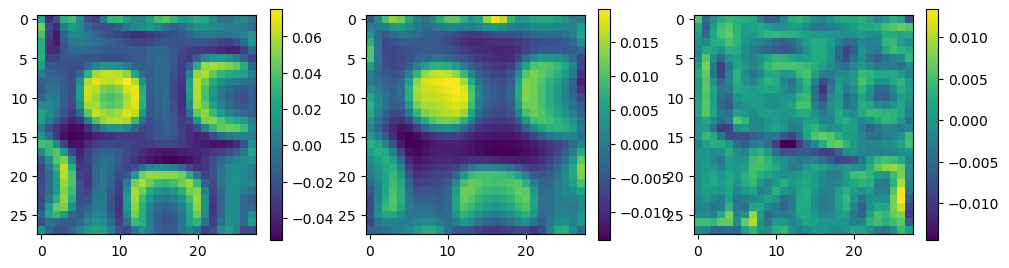

In [11]:
_ = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(A_hat-A)
print(np.sqrt(np.mean((A_hat-A)**2)))
plt.colorbar(shrink=.75)
plt.subplot(132)
plt.imshow(B_hat-B)
print(np.sqrt(np.mean((B_hat-B)**2)))
plt.colorbar(shrink=.75)
plt.subplot(133)
plt.imshow(C_hat-C)
print(np.sqrt(np.mean((C_hat-C)**2)))
plt.colorbar(shrink=.75)
plt.show()


# Second optimisation
## Find the parameters

In [12]:
estimated_params = dict()
for l, name in zip(params_list, params_name_list):    
    estimated_params[name] = l.item()

In [13]:
def get_bound(name):
    if name.startswith("K"):
        return Ks_bounds[name]
    if name.startswith("n"):
        return ns_bounds[name]
    return (np.nan,np.nan)
    

def actual_by(name):
    if name.startswith("n"):
        return params["n"]
    else:
        return params[name]
print("name \tOriginl \tEst. \tClosest Bound \tBounds")
print("-------------------------------------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{actual_by(name):.3f}\t\t"                                  
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
      for name in params_name_list
]))

name 	Originl 	Est. 	Closest Bound 	Bounds
-------------------------------------------------------------------------------------------------------------
b_A:	0.001		0.002		nan		(nan,nan)
b_B:	1.000		7.369		nan		(nan,nan)
b_C:	20.000		0.019		nan		(nan,nan)
V_A:	20.000		17.923		nan		(nan,nan)
V_B:	100.000		173.184		nan		(nan,nan)
V_C:	100.000		1.405		nan		(nan,nan)
mu_A:	1.000		1.022		nan		(nan,nan)
mu_B:	5.000		5.804		nan		(nan,nan)
mu_C:	5.000		0.005		nan		(nan,nan)
K_AA:	5.000		5.510		0.011		(0.011,140.395)
K_AB:	5.000		5.248		0.011		(0.011,140.395)
K_AC:	10.000		4.544		0.011		(0.011,140.395)
K_BA:	10.000		11.172		0.359		(0.359,204.854)
K_BC:	10.000		3.051		0.359		(0.359,204.854)
K_CB:	10.000		6.968		0.222		(0.222,92.883)
K_CC:	10.000		7.074		0.222		(0.222,92.883)
n_AA:	4.000		3.284		1.000		(1.000,6.000)
n_AB:	4.000		3.430		1.000		(1.000,6.000)
n_AC:	4.000		6.000		6.000		(1.000,6.000)
n_BA:	4.000		6.000		6.000		(1.000,6.000)
n_BC:	4.000		5.329		6.000		(1.000,6.000)
n_CB:	4.000		1.040	

In [14]:
0.260/26

0.01

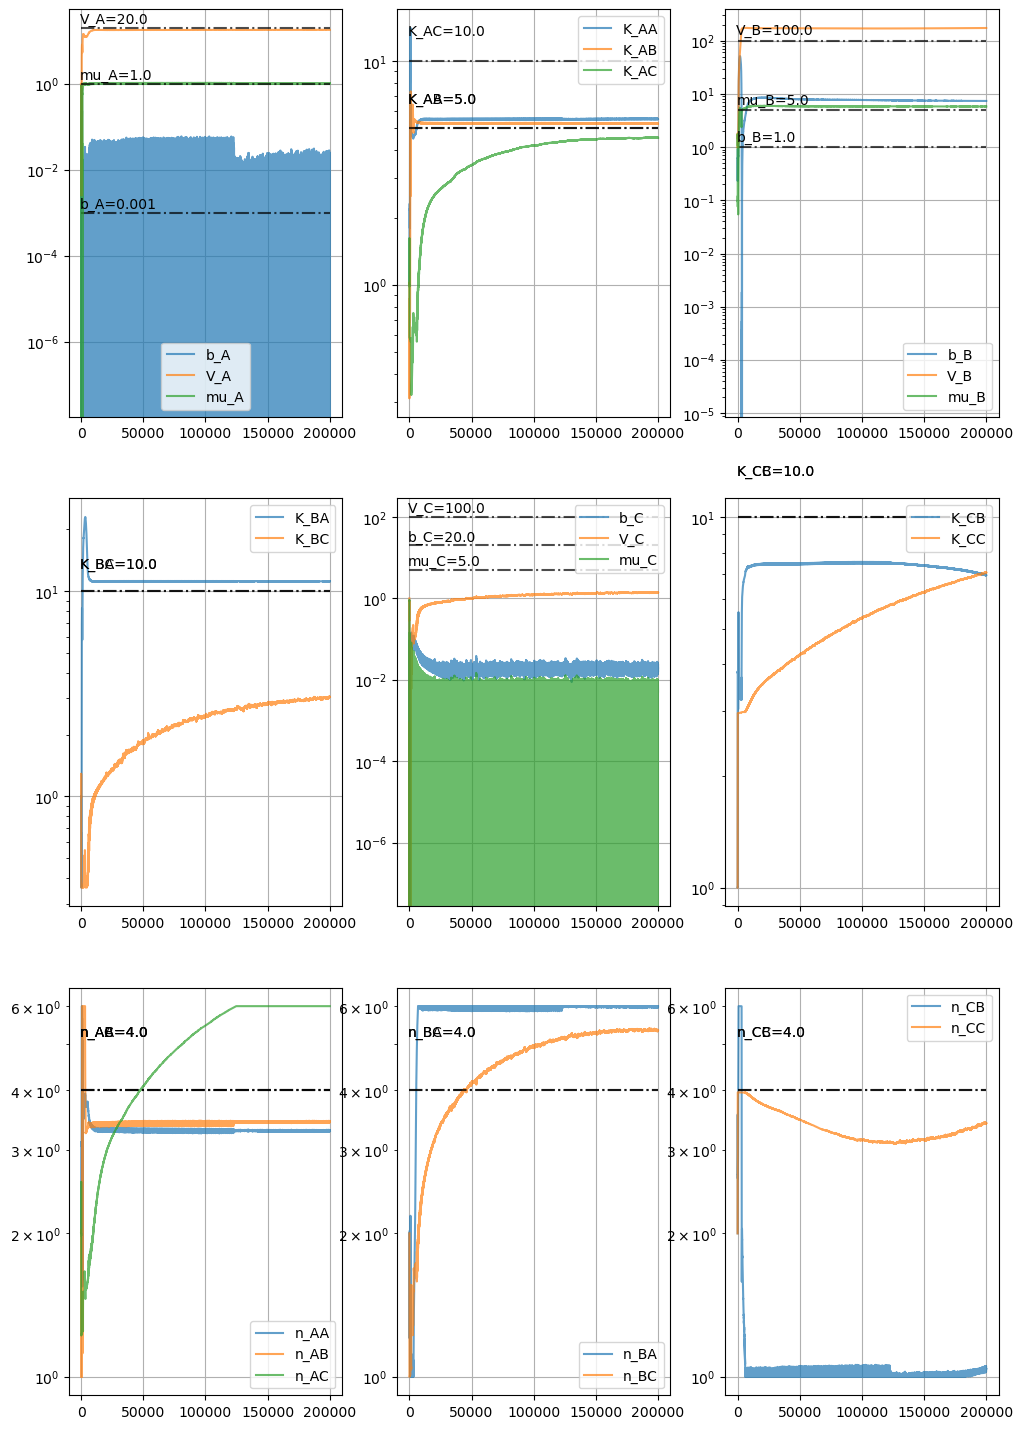

In [15]:
def plot_params(ax, names):    
    for i,(param, name) in enumerate(zip(params_list, params_name_list)):    
        if name not in names:
            continue
        ax.plot(params_sampled_list[i], label=f"{name}", alpha=.7)
        ax.hlines(actual_by(name), 0, len(params_sampled_list[i]), 
                   linestyles='-.', alpha=.7, color='black')
        ax.text(-1000, 1.3*actual_by(name), f"{name}={actual_by(name)}")
    plt.yscale('log');plt.legend();plt.grid()   
    
_ = plt.figure(figsize=(12,18))
plot_params(plt.subplot(3,3,1), ["b_A", "mu_A", "V_A"])
plot_params(plt.subplot(3,3,2), ["K_AA","K_AB","K_AC"])
plot_params(plt.subplot(3,3,3), ["b_B", "mu_B", "V_B"])
plot_params(plt.subplot(3,3,4), ["K_BA","K_BC"])
plot_params(plt.subplot(3,3,5), ["b_C", "mu_C", "V_C"])
plot_params(plt.subplot(3,3,6), ["K_CB","K_CC"])
plot_params(plt.subplot(3,3,7), ["n_AA", "n_AB", "n_AC"])
plot_params(plt.subplot(3,3,8), ["n_BA", "n_BC"])
plot_params(plt.subplot(3,3,9), ["n_CB", "n_CC"])


In [16]:
import pickle

torch.save(model, "./08_outputs/model_PINN_14")
torch.save(model.state_dict(), "./08_outputs/model_PINN_state_14")
with open('./08_outputs/model_PINN_params_name_list_14.npy', 'wb') as f:
    np.save(f, params_name_list)    
with open('./08_outputs/model_PINN_losses_14.npy', 'wb') as f:
    np.save(f, losses)    
with open(f"./08_outputs/model_PINN_estimated_params_14.pkl", "wb") as f:
    pickle.dump((dict(params),  dict(estimated_params)), f)
with open(f"./08_outputs/model_PINN_estimated_params_list_14.pkl", "wb") as f:
    pickle.dump(params_sampled_list, f)     

In [17]:
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")

sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import RD_2D_1st_Order, Neumann_Boundary_2D

D_A, D_B = 0.01, 1.0#
model_integrator = RD_2D_1st_Order(Ds=[D_A, D_B, 0], 
                        delta_t=100/5000, 
                        Lx=10, Ly=10, 
                        Ix=128, Jy=128,
                        boundary_condition=Neumann_Boundary_2D)

/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [18]:
def create_circuit_3954_2(
    b_A, mu_A, V_A, K_AA, K_AB, K_AC, b_B, mu_B, V_B, K_BA, K_BC, b_C, mu_C, V_C, K_CB, K_CC,
    n_AA, n_AB, n_AC, n_BA, n_BC, n_CB, n_CC,
):
    def circuit_3954(A, B, C):
        fA_v = b_A + V_A * act(A, K_AA, n_AA) * inh(B, K_BA, n_BA) - mu_A * A
        fB_v = b_B + V_B * act(A, K_AB, n_AB) * inh(C, K_CB, n_CB) - mu_B * B
        fC_v = b_C + V_C * inh(A, K_AC, n_AC) * inh(B, K_BC, n_BC) * act(C, K_CC, n_CC) - mu_C * C
        return (fA_v, fB_v, fC_v)
    
    return circuit_3954

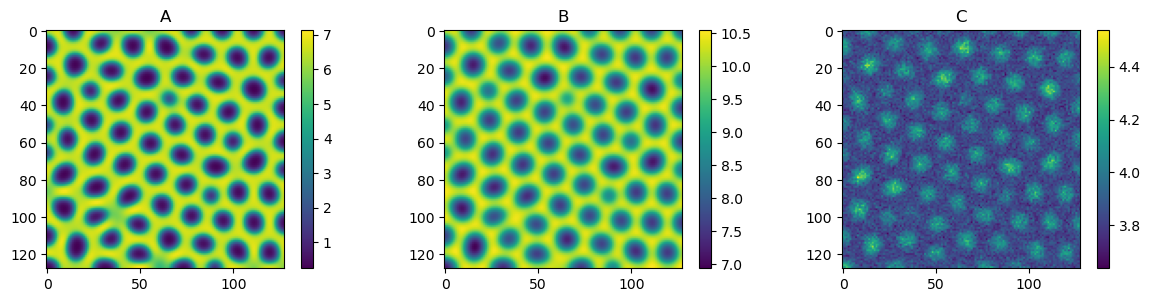

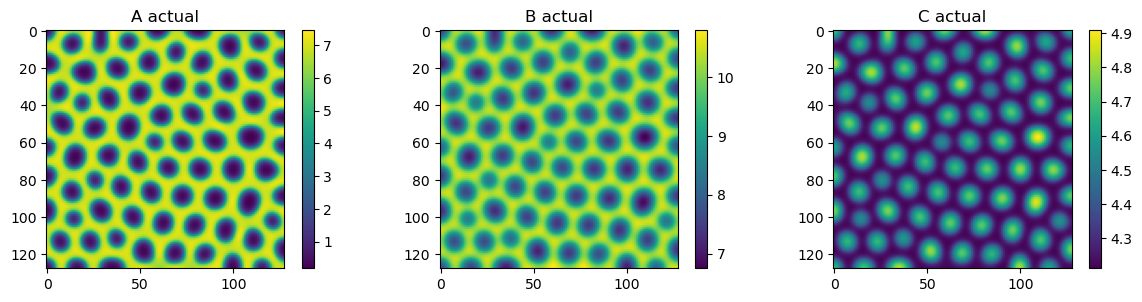

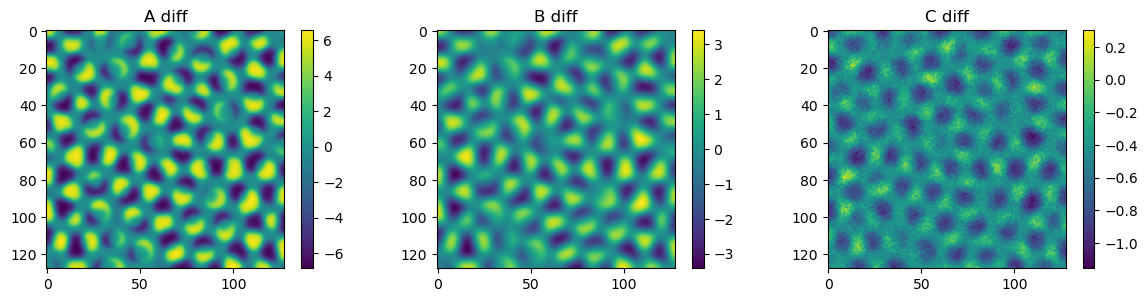

In [19]:

params2 = {}
for k,v in estimated_params.items():
    if k.startswith("K"):
        lower, upper = Ks_bounds[k]
        if v < lower:
            params2[k] = lower
        elif v > upper:
            params2[k] = upper
        else:
            params2[k] = v
    elif k.startswith("n"):
        # Round the n to its closest integer        
        params2[k] = np.rint(v)
    else:
        params2[k] = v

kinetics = create_circuit_3954_2(params2["b_A"], params2["mu_A"], params2["V_A"], 
                                 params2["K_AA"], params2["K_AB"], params2["K_AC"],
                                 params2["b_B"], params2["mu_B"], params2["V_B"], 
                                 params2["K_BA"], params2["K_BC"],
                                 params2["b_C"], params2["mu_C"], params2["V_C"], 
                                 params2["K_CB"], params2["K_CC"],
                                 params2["n_AA"], params2["n_AB"], params2["n_AC"],
                                 params2["n_BA"], params2["n_BC"],
                                 params2["n_CB"], params2["n_CC"],
                              )

(A_init, B_init, C_init) = (solution[0, 0, :, :].flatten(),
                            solution[0, 1, :, :].flatten(),
                            solution[0, 2, :, :].flatten())
solution_test = model_integrator.integrate([A_init, B_init, C_init],kinetics, 4*5000, record_steps=5000)

A_test = solution_test[-1,0, :].reshape((128,128))
B_test = solution_test[-1,1, :].reshape((128,128))
C_test = solution_test[-1,2, :].reshape((128,128))
plot_n_im([A_test,B_test,C_test], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([solution[105, 0, :, :],solution[105, 1, :, :],solution[105, 2, :, :]], 
           ["A actual","B actual","C actual"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([A_test-solution[105, 0, :, :],
           B_test-solution[105, 1, :, :],
           C_test-solution[105, 2, :, :]], 
           ["A diff","B diff","C diff"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

In [20]:
{1:31,
2:3,
3:9, 
4:25,
5:14,
6:60,
7:24,
8:26,
9:65}

{1: 31, 2: 3, 3: 9, 4: 25, 5: 14, 6: 60, 7: 24, 8: 26, 9: 65}